### Random Forest Classification Model - Baseline

In [2]:
import cv2

from itertools import cycle
import matplotlib.pyplot as plt
import math
import numpy as np
import pandas as pd


from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (classification_report,accuracy_score,confusion_matrix, precision_score, recall_score, f1_score,roc_auc_score,roc_curve,auc)
from sklearn.preprocessing import LabelBinarizer
import seaborn as sns

from tqdm import tqdm

In [3]:
labels = [
    "Preparation",
    "CalotTriangleDissection",
    "ClippingCutting",
    "GallbladderDissection",
    "GallbladderPackaging",
    "CleaningCoagulation",
    "GallbladderRetraction",
]

In [6]:
train_df = pd.read_parquet('data/ordered_train_df.parquet')
val_df = pd.read_parquet('data/ordered_val_df.parquet')
test_df = pd.read_parquet('data/ordered_test_df.parquet')

train_df = train_df[train_df['frame'] % 25 == 0].reset_index(drop=True)
val_df = val_df[val_df['frame'] % 25 == 0].reset_index(drop=True)
test_df = test_df[test_df['frame'] % 25 == 0].reset_index(drop=True)

In [7]:
#train and val together
train_df = pd.concat([train_df,val_df])

In [6]:
# min_represent_class_num = train_df.groupby('phase').count().min()[0]
# balanced_train_df = train_df.groupby("phase").sample(n=min_represent_class_num, random_state=42)

In [19]:
def select_optimum_components(var_ratio, goal_var):
    total_variance = 0.0
    n_components = 0
    for explained_variance in var_ratio:
        total_variance += explained_variance
        n_components += 1

        if total_variance >= goal_var:
            break
    return n_components


def get_mean_ci_interval(values):
    x_bar = np.mean(values)
    s = np.std(values)
    n = len(values)
    z = 1.96 

    lower = x_bar - (z * (s/math.sqrt(n)))
    upper = x_bar + (z * (s/math.sqrt(n)))


    return lower, x_bar, upper

In [7]:
def img_to_numpy_flat_w_pca(img_paths):
    all_images = []
    for img_path in tqdm(img_paths):
        img = cv2.imread(img_path)   
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        blue, green, red = cv2.split(img)

        #Scale 
        blue_scaled = blue /255
        green_scaled = green / 255
        red_scaled = red / 255

        #apply PCA 4 components
        pca_blue = PCA(n_components=4)
        pca_blue_transform = pca_blue.fit_transform(blue_scaled)
        pca_green = PCA(n_components=4)
        pca_green_transform = pca_green.fit_transform(green_scaled)
        pca_red = PCA(n_components=4)
        pca_red_transform = pca_red.fit_transform(red_scaled)


        #Reverse transformation to get back pixel data
        blue = pca_blue.inverse_transform(pca_blue_transform)
        green = pca_green.inverse_transform(pca_green_transform)
        red = pca_red.inverse_transform(pca_red_transform)

        img = cv2.merge((pca_blue_transform, pca_green_transform, pca_red_transform))
        img = img.flatten()
        all_images.append(img)
    all_images = np.array(all_images)
    return all_images 

In [8]:
X_train = img_to_numpy_flat_w_pca(train_df['image'].to_numpy())
y_train = train_df['phase'].to_numpy()

 33%|███▎      | 35863/107784 [26:53<56:15, 21.31it/s]  c:\Users\vkula\anaconda3\lib\site-packages\sklearn\decomposition\_pca.py:470: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ratio_ = explained_variance_ / total_var
c:\Users\vkula\anaconda3\lib\site-packages\sklearn\decomposition\_pca.py:470: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ratio_ = explained_variance_ / total_var
c:\Users\vkula\anaconda3\lib\site-packages\sklearn\decomposition\_pca.py:470: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ratio_ = explained_variance_ / total_var
 33%|███▎      | 35866/107784 [26:53<54:12, 22.11it/s]c:\Users\vkula\anaconda3\lib\site-packages\sklearn\decomposition\_pca.py:470: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ratio_ = explained_variance_ / total_var
c:\Users\vkula\anaconda3\lib\site-packages\sklearn\decomposition\_pca.py:470: RuntimeWarning: invalid 

In [43]:
# X_val = img_to_numpy_flat_w_pca(val_df['image'].to_numpy())
# y_val = val_df['phase'].to_numpy()

 51%|█████     | 12018/23770 [08:41<08:38, 22.67it/s]c:\Users\vkula\anaconda3\lib\site-packages\sklearn\decomposition\_pca.py:470: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ratio_ = explained_variance_ / total_var
c:\Users\vkula\anaconda3\lib\site-packages\sklearn\decomposition\_pca.py:470: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ratio_ = explained_variance_ / total_var
c:\Users\vkula\anaconda3\lib\site-packages\sklearn\decomposition\_pca.py:470: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ratio_ = explained_variance_ / total_var
100%|██████████| 23770/23770 [17:37<00:00, 22.47it/s]


In [9]:
X_test = img_to_numpy_flat_w_pca(test_df['image'].to_numpy())
y_test = test_df['phase'].to_numpy()

100%|██████████| 76783/76783 [1:00:44<00:00, 21.07it/s]


In [18]:
pd.DataFrame(X_train, columns=pd.DataFrame(X_train).columns.astype('string')).to_parquet('rf_X_train_ord.parquet',engine='pyarrow')

In [19]:
pd.DataFrame(X_test, columns=pd.DataFrame(X_test).columns.astype('string')).to_parquet('rf_X_test_ord.parquet',engine='pyarrow')

In [ ]:
#Save PCA'd 1D images
pd.DataFrame(X_train, columns=pd.DataFrame(X_train).columns.astype('string')).to_parquet('rf_X_train_ord.parquet')
# pd.DataFrame(X_val, columns=pd.DataFrame(X_val).columns.astype('string')).to_parquet('rf_X_val.parquet')
pd.DataFrame(X_test, columns=pd.DataFrame(X_test).columns.astype('string')).to_parquet('rf_X_test_ord.parquet')

In [8]:
X_train = pd.read_parquet('rf_X_train_ord.parquet').to_numpy()
X_test = pd.read_parquet('rf_X_test_ord.parquet').to_numpy()
y_train = train_df['phase'].to_numpy()
y_test = test_df['phase'].to_numpy()

In [11]:
np.unique(y_train).shape[0]

7

In [12]:
rf_feat_import = RandomForestClassifier(
    n_estimators=200,
    max_features="auto",
    class_weight="balanced",
    max_depth=np.unique(y_train).shape[0],
    random_state=42,
    verbose=2)

rf_feat_import.fit(X_train,y_train)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


building tree 1 of 200


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.8s remaining:    0.0s


building tree 2 of 200
building tree 3 of 200
building tree 4 of 200
building tree 5 of 200
building tree 6 of 200
building tree 7 of 200
building tree 8 of 200
building tree 9 of 200
building tree 10 of 200
building tree 11 of 200
building tree 12 of 200
building tree 13 of 200
building tree 14 of 200
building tree 15 of 200
building tree 16 of 200
building tree 17 of 200
building tree 18 of 200
building tree 19 of 200
building tree 20 of 200
building tree 21 of 200
building tree 22 of 200
building tree 23 of 200
building tree 24 of 200
building tree 25 of 200
building tree 26 of 200
building tree 27 of 200
building tree 28 of 200
building tree 29 of 200
building tree 30 of 200
building tree 31 of 200
building tree 32 of 200
building tree 33 of 200
building tree 34 of 200
building tree 35 of 200
building tree 36 of 200
building tree 37 of 200
building tree 38 of 200
building tree 39 of 200
building tree 40 of 200
building tree 41 of 200
building tree 42 of 200
building tree 43 of 200


[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:  6.4min finished


RandomForestClassifier(class_weight='balanced', max_depth=7, n_estimators=200,
                       random_state=42, verbose=2)

<AxesSubplot:title={'center':'Feature Importance'}, ylabel='GINI Importancve'>

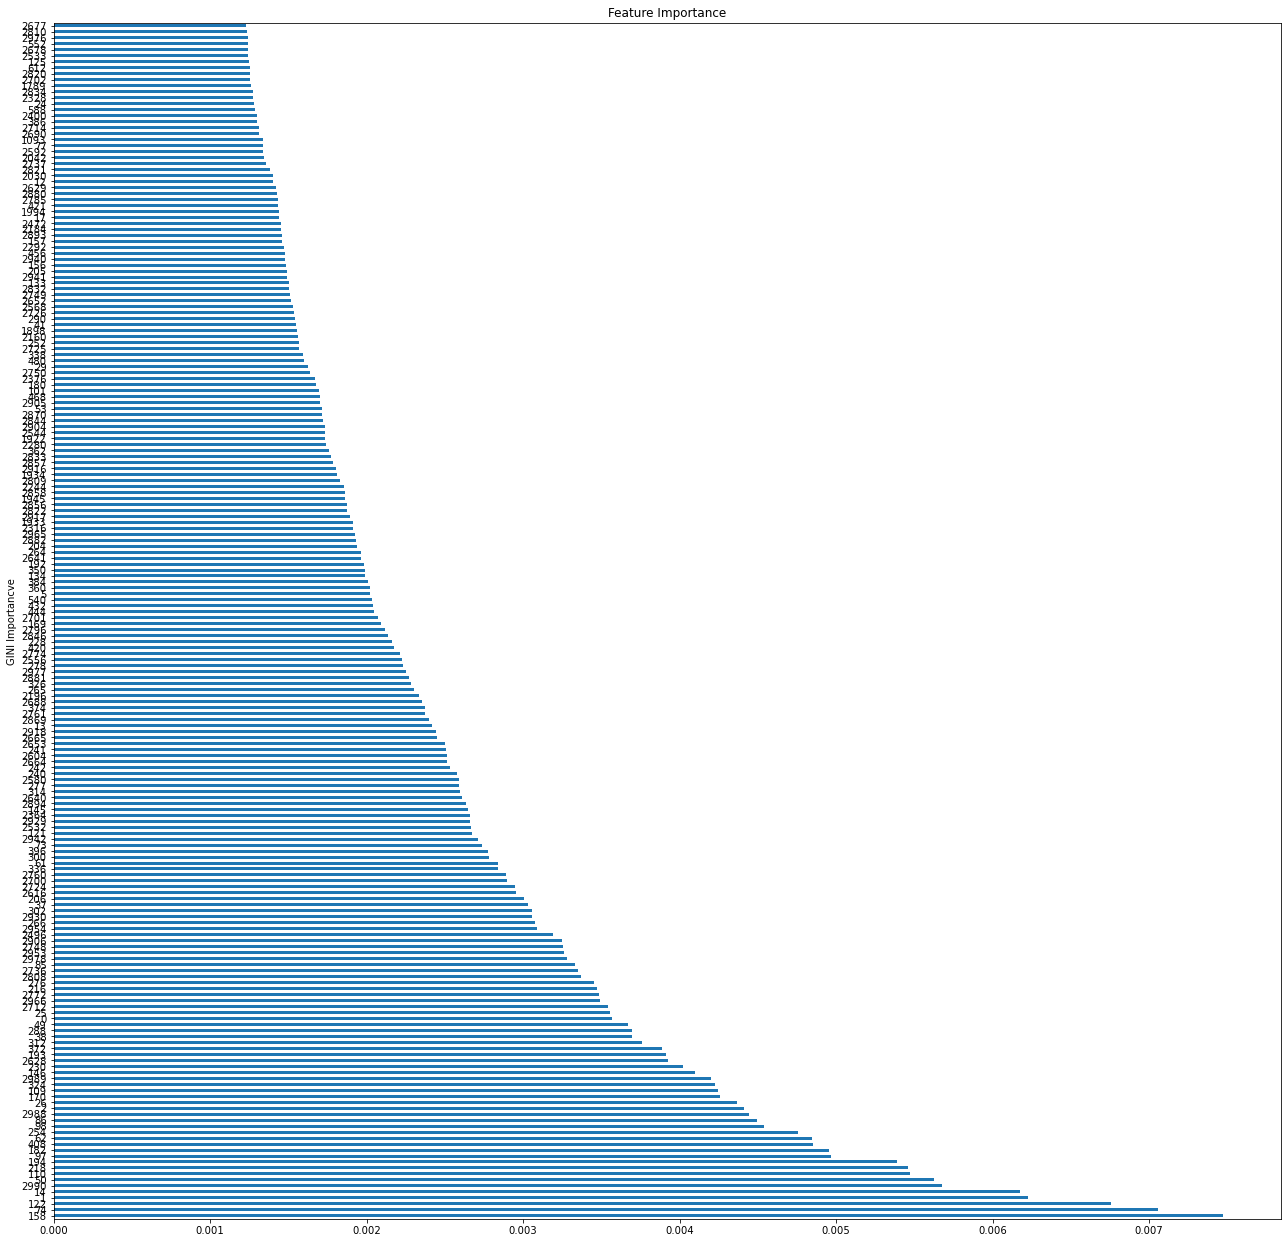

In [14]:
pd.Series(rf_feat_import.feature_importances_).nlargest(200).plot(kind="barh", figsize=(22,22),xlabel="GINI Importancve", title="Feature Importance")

In [16]:
X_train_instr = train_df.iloc[:,4:-1].to_numpy()
# X_val_instr = val_df.iloc[:,4:-1].to_numpy()
X_test_instr = test_df.iloc[:,4:-1].to_numpy()

In [61]:
from sklearn.utils import class_weight

#Get train label weights and convert to torch tensor
phase_weights=class_weight.compute_class_weight('balanced',classes=np.unique(train_df['phase']),y=train_df['phase'].to_numpy())
phase_weights

array([3.07585183, 0.34536413, 1.78420791, 0.48659191, 3.34587446,
       1.68982817, 3.6608926 ])

### Random Forest With Images Only

In [17]:
# instantiate the classifier 
random_forest = RandomForestClassifier(n_estimators=200,
    max_features="auto",
    class_weight="balanced",
    max_depth=np.unique(y_train).shape[0],
    random_state=42,
    verbose=2)

# fit
random_forest.fit(X_train, y_train)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


building tree 1 of 200


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.8s remaining:    0.0s


building tree 2 of 200
building tree 3 of 200
building tree 4 of 200
building tree 5 of 200
building tree 6 of 200
building tree 7 of 200
building tree 8 of 200
building tree 9 of 200
building tree 10 of 200
building tree 11 of 200
building tree 12 of 200
building tree 13 of 200
building tree 14 of 200
building tree 15 of 200
building tree 16 of 200
building tree 17 of 200
building tree 18 of 200
building tree 19 of 200
building tree 20 of 200
building tree 21 of 200
building tree 22 of 200
building tree 23 of 200
building tree 24 of 200
building tree 25 of 200
building tree 26 of 200
building tree 27 of 200
building tree 28 of 200
building tree 29 of 200
building tree 30 of 200
building tree 31 of 200
building tree 32 of 200
building tree 33 of 200
building tree 34 of 200
building tree 35 of 200
building tree 36 of 200
building tree 37 of 200
building tree 38 of 200
building tree 39 of 200
building tree 40 of 200
building tree 41 of 200
building tree 42 of 200
building tree 43 of 200


[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:  6.4min finished


RandomForestClassifier(class_weight='balanced', max_depth=7, n_estimators=200,
                       random_state=42, verbose=2)

In [ ]:
X_test_df = pd.DataFrame(X_test)
X_test_df['video_num'] = test_df['video_num']
X_test_df['phase'] = test_df['phase']
test_labels = []
test_predicted = []
test_score = []
test_prec = []
test_rec = []
test_f1 = []
for i,group in X_test_df.groupby('video_num'):
    video_test = group.iloc[:,:-2].to_numpy()
    y_pred = random_forest.predict(video_test)
    y_gt = group['phase'].to_numpy()
    result = accuracy_score(y_gt, y_pred)
    
    prec = precision_score(y_gt, y_pred,average='weighted')
    rec = recall_score(y_gt, y_pred,average='weighted')
    f1 = f1_score(y_gt, y_pred,average='weighted')

    
    test_prec.append(prec)
    test_rec.append(rec)
    test_f1.append(f1)

    test_labels.append(y_gt)
    test_predicted.append(y_pred)
    test_score.append(result)
    print('{0:0.2f}%'. format(result * 100))
lower,mean ,upper = get_mean_ci_interval(test_score)
print(f'Results are average acuracy of: {round(mean,3)}% ±  {round(mean-lower,3)}')

In [21]:
print(f'Precision mean for all vids is: {np.mean(test_prec)} +- {1.96 * np.std(test_prec) / np.sqrt(len(test_prec))}')
print(f'Recall mean for all vids is: {np.mean(test_rec)} +- {1.96 * np.std(test_rec) / np.sqrt(len(test_rec))}')
print(f'F1 Score mean for all vids is: {np.mean(test_f1)} +- {1.96 * np.std(test_f1) / np.sqrt(len(test_f1))}')

Precision mean for all vids is: 0.4097432562202581 +- 0.03333570517286462
Recall mean for all vids is: 0.28840582345858434 +- 0.02472747408854409
F1 Score mean for all vids is: 0.3098077819967448 +- 0.02754298790703518


In [22]:
y_labels = np.concatenate(test_labels)
y_preds = np.concatenate(test_predicted)
print(classification_report(y_labels, y_preds,digits=4,labels=np.unique(y_labels),target_names=labels))

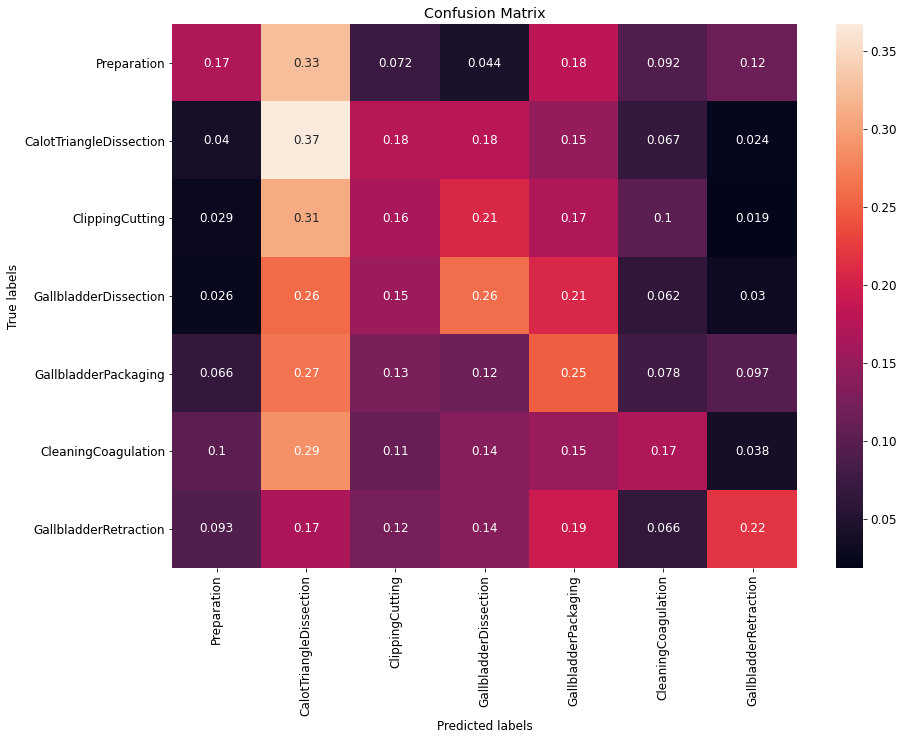

In [24]:
cm = confusion_matrix(y_labels, y_preds)

# Plot the confusion matrix
plt.rcParams.update({"font.size": 12})
fig = plt.figure(figsize=(14, 10))
ax= plt.subplot()
# sns.heatmap(cm.astype('float'), annot=True, ax=ax) 
# To show fractions, please uncomment the following line and comment the above
sns.heatmap(cm.astype('float') / cm.sum(axis=1)[:, np.newaxis], annot=True, fmt='.2', ax=ax) 
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix')
ax.xaxis.set_ticklabels(labels, rotation=90)
ax.yaxis.set_ticklabels(labels, rotation=0)
plt.show()

### Random Forest With Instruments Only

In [25]:
X_train_instr = train_df.iloc[:,4:-1].to_numpy()
# X_val_instr = val_df.iloc[:,4:-1].to_numpy()
X_test_instr = test_df.iloc[:,4:-1].to_numpy()


# instantiate the classifier 
random_forest_inst_only = RandomForestClassifier(n_estimators=200,
    max_features="auto",
    class_weight="balanced",
    max_depth=np.unique(y_train).shape[0],
    random_state=42,
    verbose=2)
# fit
random_forest_inst_only.fit(X_train_instr, y_train)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


building tree 1 of 200
building tree 2 of 200
building tree 3 of 200
building tree 4 of 200
building tree 5 of 200
building tree 6 of 200
building tree 7 of 200
building tree 8 of 200
building tree 9 of 200
building tree 10 of 200
building tree 11 of 200
building tree 12 of 200
building tree 13 of 200
building tree 14 of 200
building tree 15 of 200
building tree 16 of 200
building tree 17 of 200
building tree 18 of 200
building tree 19 of 200
building tree 20 of 200
building tree 21 of 200
building tree 22 of 200
building tree 23 of 200
building tree 24 of 200
building tree 25 of 200
building tree 26 of 200
building tree 27 of 200
building tree 28 of 200
building tree 29 of 200
building tree 30 of 200
building tree 31 of 200
building tree 32 of 200
building tree 33 of 200
building tree 34 of 200
building tree 35 of 200
building tree 36 of 200
building tree 37 of 200
building tree 38 of 200
building tree 39 of 200
building tree 40 of 200
building tree 41 of 200
building tree 42 of 200
b

[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    1.5s finished


RandomForestClassifier(class_weight='balanced', max_depth=7, n_estimators=200,
                       random_state=42, verbose=2)

In [ ]:
X_test_df = pd.DataFrame(X_test_instr)
X_test_df['video_num'] = test_df['video_num']
X_test_df['phase'] = test_df['phase']
test_labels = []
test_predicted = []
test_score = []
test_prec = []
test_rec = []
test_f1 = []
for i,group in X_test_df.groupby('video_num'):
    video_test = group.iloc[:,:-2].to_numpy()
    y_pred = random_forest_inst_only.predict(video_test)
    y_gt = group['phase'].to_numpy()
    result = accuracy_score(y_gt, y_pred)
    
    prec = precision_score(y_gt, y_pred,average='weighted')
    rec = recall_score(y_gt, y_pred,average='weighted')
    f1 = f1_score(y_gt, y_pred,average='weighted')

    
    test_prec.append(prec)
    test_rec.append(rec)
    test_f1.append(f1)

    test_labels.append(y_gt)
    test_predicted.append(y_pred)
    test_score.append(result)
    print('{0:0.2f}%'. format(result * 100))
lower,mean ,upper = get_mean_ci_interval(test_score)
print(f'Results are average acuracy of: {round(mean,3)}% ±  {round(mean-lower,3)}')

In [27]:
print(f'Precision mean for all vids is: {np.mean(test_prec)} +- {1.96 * np.std(test_prec) / np.sqrt(len(test_prec))}')
print(f'Recall mean for all vids is: {np.mean(test_rec)} +- {1.96 * np.std(test_rec) / np.sqrt(len(test_rec))}')
print(f'F1 Score mean for all vids is: {np.mean(test_f1)} +- {1.96 * np.std(test_f1) / np.sqrt(len(test_f1))}')

Precision mean for all vids is: 0.6260501231278668 +- 0.03118442177121882
Recall mean for all vids is: 0.48696154997322316 +- 0.03231105229856343
F1 Score mean for all vids is: 0.5105533701281657 +- 0.033027284760945644


In [28]:
y_labels = np.concatenate(test_labels)
y_preds = np.concatenate(test_predicted)
print(classification_report(y_labels, y_preds,digits=4,labels=np.unique(y_labels),target_names=labels))

                         precision    recall  f1-score   support

            Preparation     0.1774    0.4482    0.2542      3568
CalotTriangleDissection     0.6039    0.3701    0.4589     30242
        ClippingCutting     0.9564    0.6037    0.7402      5450
  GallbladderDissection     0.5344    0.4833    0.5076     26789
   GallbladderPackaging     0.7747    0.7888    0.7817      3016
    CleaningCoagulation     0.4723    0.5541    0.5100      5223
  GallbladderRetraction     0.1268    0.6289    0.2111      2495

               accuracy                         0.4672     76783
              macro avg     0.5209    0.5539    0.4948     76783
           weighted avg     0.5671    0.4672    0.4945     76783



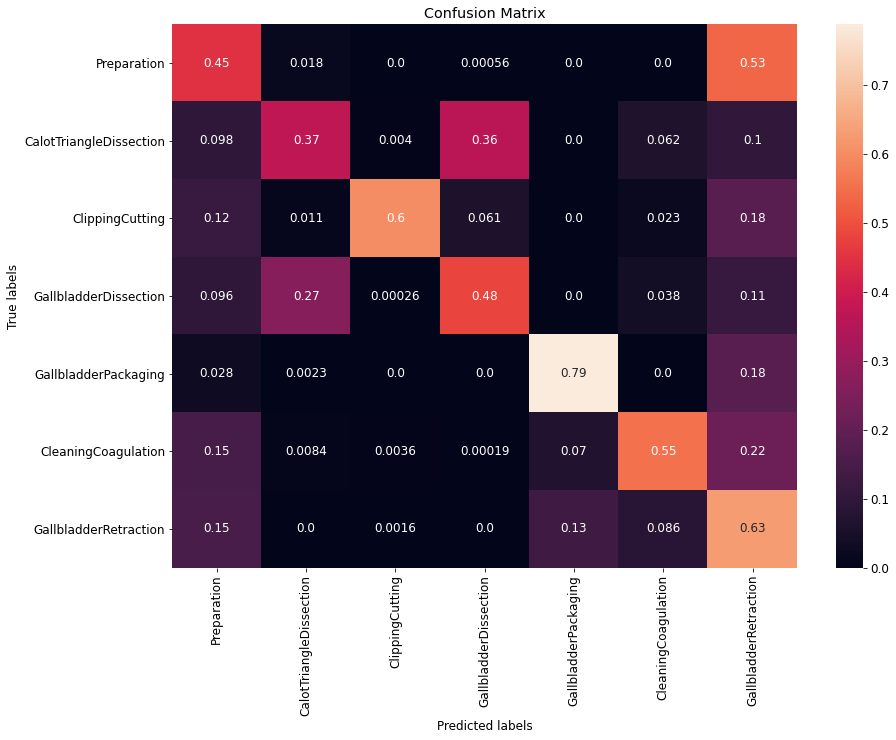

In [29]:
cm = confusion_matrix(y_labels, y_preds)

# Plot the confusion matrix
plt.rcParams.update({"font.size": 12})
fig = plt.figure(figsize=(14, 10))
ax= plt.subplot()
# sns.heatmap(cm.astype('float'), annot=True, ax=ax) 
# To show fractions, please uncomment the following line and comment the above
sns.heatmap(cm.astype('float') / cm.sum(axis=1)[:, np.newaxis], annot=True, fmt='.2', ax=ax) 
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix')
ax.xaxis.set_ticklabels(labels, rotation=90)
ax.yaxis.set_ticklabels(labels, rotation=0)
plt.show()

### Random Forest With Images + Instruments 

In [30]:
#Add instruments to numpy array
X_train_instr = train_df.iloc[:,4:-1].to_numpy()
# X_val_instr = val_df.iloc[:,4:-1].to_numpy()
X_test_instr = test_df.iloc[:,4:-1].to_numpy()
X_train_full = np.concatenate((X_train, X_train_instr), axis=1)
# X_val_full = np.concatenate((X_val, X_val_instr), axis=1)
X_test_full = np.concatenate((X_test, X_test_instr), axis=1)

In [31]:
# instantiate the classifier 
random_forest_inst = RandomForestClassifier(n_estimators=200,
    max_features="auto",
    class_weight="balanced",
    max_depth=np.unique(y_train).shape[0],
    random_state=42,
    verbose=2)
# fit
random_forest_inst.fit(X_train_full, y_train)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


building tree 1 of 200


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.7s remaining:    0.0s


building tree 2 of 200
building tree 3 of 200
building tree 4 of 200
building tree 5 of 200
building tree 6 of 200
building tree 7 of 200
building tree 8 of 200
building tree 9 of 200
building tree 10 of 200
building tree 11 of 200
building tree 12 of 200
building tree 13 of 200
building tree 14 of 200
building tree 15 of 200
building tree 16 of 200
building tree 17 of 200
building tree 18 of 200
building tree 19 of 200
building tree 20 of 200
building tree 21 of 200
building tree 22 of 200
building tree 23 of 200
building tree 24 of 200
building tree 25 of 200
building tree 26 of 200
building tree 27 of 200
building tree 28 of 200
building tree 29 of 200
building tree 30 of 200
building tree 31 of 200
building tree 32 of 200
building tree 33 of 200
building tree 34 of 200
building tree 35 of 200
building tree 36 of 200
building tree 37 of 200
building tree 38 of 200
building tree 39 of 200
building tree 40 of 200
building tree 41 of 200
building tree 42 of 200
building tree 43 of 200


[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:  6.4min finished


RandomForestClassifier(class_weight='balanced', max_depth=7, n_estimators=200,
                       random_state=42, verbose=2)

In [ ]:
X_test_df = pd.DataFrame(X_test_full)
X_test_df['video_num'] = test_df['video_num']
X_test_df['phase'] = test_df['phase']
test_labels_inst = []
test_predicted_inst = []
test_score_inst = []
test_prec = []
test_rec = []
test_f1 = []
for i,group in X_test_df.groupby('video_num'):
    video_test = group.iloc[:,:-2].to_numpy()
    y_pred = random_forest_inst.predict(video_test)
    y_gt = group['phase'].to_numpy()
    result = accuracy_score(y_gt, y_pred)

    prec = precision_score(y_gt, y_pred,average='weighted')
    rec = recall_score(y_gt, y_pred,average='weighted')
    f1 = f1_score(y_gt, y_pred,average='weighted')

    test_prec.append(prec)
    test_rec.append(rec)
    test_f1.append(f1)

    test_labels_inst.append(y_gt)
    test_predicted_inst.append(y_pred)
    test_score_inst.append(result)
    print('{0:0.2f}%'. format(result * 100))
lower,mean ,upper = get_mean_ci_interval(test_score_inst)
print(f'Results are average acuracy of: {round(mean,3)}% ±  {round(mean-lower,3)}')

In [33]:
print(f'Precision mean for all vids is: {np.mean(test_prec)} +- {1.96 * np.std(test_prec) / np.sqrt(len(test_prec))}')
print(f'Recall mean for all vids is: {np.mean(test_rec)} +- {1.96 * np.std(test_rec) / np.sqrt(len(test_rec))}')
print(f'F1 Score mean for all vids is: {np.mean(test_f1)} +- {1.96 * np.std(test_f1) / np.sqrt(len(test_f1))}')

Precision mean for all vids is: 0.5516715847030893 +- 0.02842629796678857
Recall mean for all vids is: 0.48750688729806557 +- 0.02853186695115839
F1 Score mean for all vids is: 0.4844969472904721 +- 0.028370510309663696


In [34]:
y_labels_inst = np.concatenate(test_labels_inst)
y_preds_inst = np.concatenate(test_predicted_inst)

In [35]:
print(classification_report(y_labels_inst, y_preds_inst,digits= 4, labels=np.unique(y_labels_inst),target_names=labels))

                         precision    recall  f1-score   support

            Preparation     0.2165    0.2099    0.2131      3568
CalotTriangleDissection     0.5519    0.5137    0.5321     30242
        ClippingCutting     0.4196    0.6793    0.5187      5450
  GallbladderDissection     0.5374    0.3988    0.4578     26789
   GallbladderPackaging     0.3626    0.7861    0.4963      3016
    CleaningCoagulation     0.3877    0.5265    0.4466      5223
  GallbladderRetraction     0.2032    0.2317    0.2165      2495

               accuracy                         0.4736     76783
              macro avg     0.3827    0.4780    0.4116     76783
           weighted avg     0.4919    0.4736    0.4729     76783



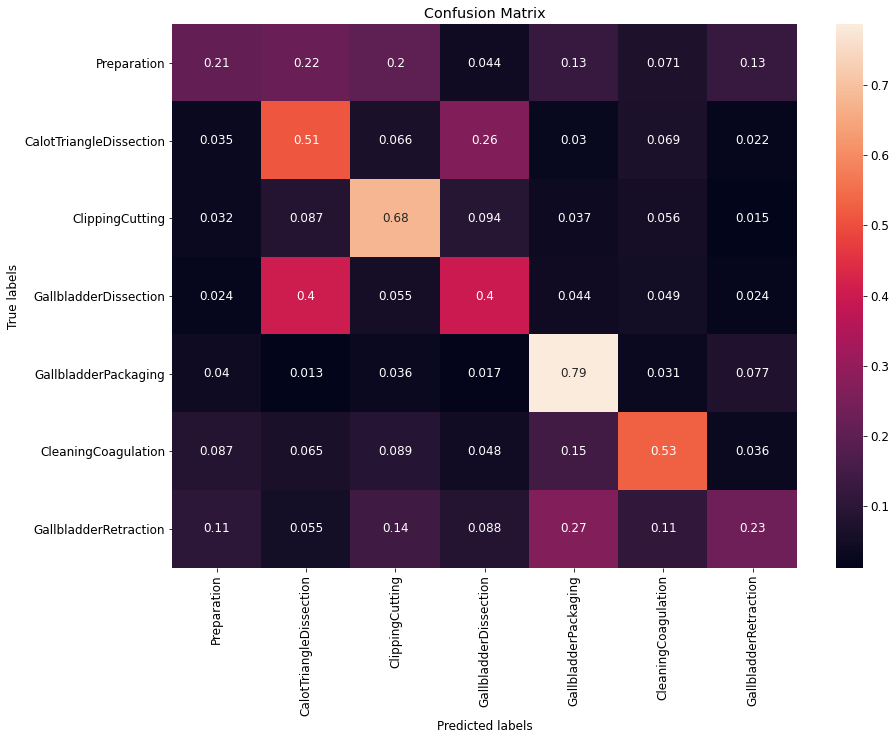

In [36]:
cm = confusion_matrix(y_labels_inst, y_preds_inst)

# Plot the confusion matrix
plt.rcParams.update({"font.size": 12})
fig = plt.figure(figsize=(14, 10))
ax= plt.subplot()
# sns.heatmap(cm.astype('float'), annot=True, ax=ax) 
# To show fractions, please uncomment the following line and comment the above
sns.heatmap(cm.astype('float') / cm.sum(axis=1)[:, np.newaxis], annot=True, fmt='.2', ax=ax) 
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix')
ax.xaxis.set_ticklabels(labels, rotation=90)
ax.yaxis.set_ticklabels(labels, rotation=0)
plt.show()

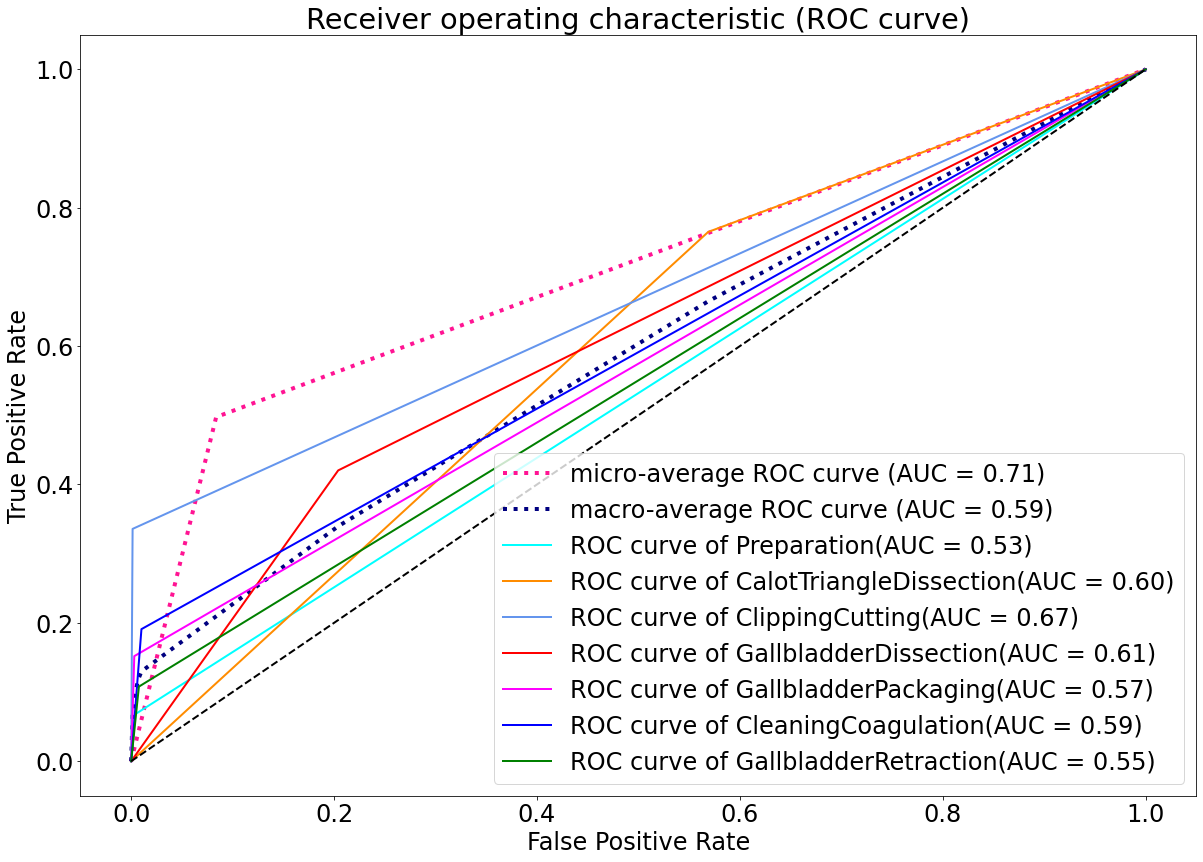

In [94]:
# plot the ROC curve
n_classes = 7
lw = 2

lb = LabelBinarizer()
lb.fit(y_labels_inst)

y_actual = lb.transform(y_labels_inst)
y_pred = lb.transform(y_preds_inst)

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(
        y_actual[:, i], y_pred[:, i], drop_intermediate=True)
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_actual.ravel(), y_pred.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

font = {"family": "DejaVu Sans", "size": 24}
plt.rc("font", **font)
# Plot all ROC curves
plt.figure(figsize=(20, 14))
plt.plot(
    fpr["micro"],
    tpr["micro"],
    label="micro-average ROC curve (AUC = {0:0.2f})" "".format(
        roc_auc["micro"]),
    color="deeppink",
    linestyle=":",
    linewidth=4,
)

plt.plot(
    fpr["macro"],
    tpr["macro"],
    label="macro-average ROC curve (AUC = {0:0.2f})" "".format(
        roc_auc["macro"]),
    color="navy",
    linestyle=":",
    linewidth=4,
)

colors = cycle(
    ["aqua", "darkorange", "cornflowerblue", "red", "magenta", "blue", "green"]
)


for i, color in zip(range(n_classes), colors):
    plt.plot(
        fpr[i],
        tpr[i],
        color=color,
        lw=lw,
        label="ROC curve of " + str(labels[i]) + "(AUC = {1:0.2f})"
        "".format(i, roc_auc[i]),
    )

plt.plot([0, 1], [0, 1], "k--", lw=lw)
# plt.xlim([0.0, 1.00])
# plt.ylim([0.0, 1.00])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver operating characteristic (ROC curve)")
plt.legend(loc="lower right")
plt.show()